In [1]:
import os
import sys
import cv2
import tqdm
import time
import random
import scipy.io
import itertools
import numpy as np
from math import ceil
from itertools import chain
from tqdm.contrib import tzip
import matplotlib.pyplot as plt
from skimage.io import imread
from scipy.ndimage.filters import gaussian_filter
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [3]:
%run ./CCNN_model.ipynb
%run ./data_utils.ipynb

In [4]:
TEST_DATA_PATH = '../../data/part_B/test_data/'
TRAIN_DATA_PATH = '../../data/part_B/train_data/'

In [5]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' ## also i can install nomkl
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [6]:
BATCH_SIZE = 12
NUM_INPUT_CHANNELS = 1
NUM_OUTPUT_CHANNELS = 1
NUM_EPOCHS = 50
LEARNING_RATE = 3e-5
MOMENTUM = 0.9

In [7]:
transform = T.Compose([
            T.ToPILImage(),
            T.Grayscale(num_output_channels=1),
            T.ToTensor(),
            T.Normalize((0.4), (0.4))
        ])

In [8]:
train_data = ShanghaitechDataset(TRAIN_DATA_PATH, transform, size = 300)
test_data = ShanghaitechDataset(TRAIN_DATA_PATH, transform, size = 20)

print()
print('train set:\t', len(train_data))
print('test set:\t', len(test_data))

  0%|          | 0/400 [00:00<?, ?it/s]

Datasets' length: 400


  0%|          | 0/400 [00:00<?, ?it/s]

Datasets' length afte aug: 3600


  0%|          | 0/400 [00:00<?, ?it/s]

Datasets' length: 400


  0%|          | 0/400 [00:00<?, ?it/s]

Datasets' length afte aug: 3600

train set:	 300
test set:	 20


In [9]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_data, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


batch of images shape torch.Size([12, 1, 260, 260])
batch of labels shape torch.Size([12, 66, 66])


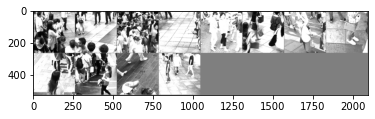

In [10]:
dataiter = iter(train_loader)
images, label = dataiter.next()
print('batch of images shape', images.shape)
print('batch of labels shape', label.shape)
imshow(torchvision.utils.make_grid(images))

In [11]:
class L2Loss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(L2Loss, self).__init__()
 
    def forward(self, inputs, targets):        
        norm = torch.dist(inputs, targets, 2) / inputs.shape[0]
        return norm

In [12]:
%run ./CCNN_model.ipynb

model = CCNN(NUM_INPUT_CHANNELS, NUM_OUTPUT_CHANNELS)

# criterion = torch.nn.MSELoss()
criterion = L2Loss()

optimizer = torch.optim.SGD(model.parameters(), lr=4e-5, momentum = MOMENTUM)

In [13]:
optimizer = torch.optim.SGD(model.parameters(), lr=5e-5, momentum = MOMENTUM)

In [ ]:
losses1, t_losses1, MSElosses1, MSEt_losses1 = train(model, train_loader, test_loader, criterion, optimizer, NUM_EPOCHS = 5, load = False)


Epochs:	 5
batch loss: 0.8965218663215637
batch MSE loss: 0.0022142319940030575
batch loss: 0.853328287601471
batch MSE loss: 0.0020059901289641857
batch loss: 1.0534216165542603
batch MSE loss: 0.0030570693779736757
batch loss: 0.7540402412414551
batch MSE loss: 0.0015663615195080638
batch loss: 0.7457807064056396
batch MSE loss: 0.001532257767394185
batch loss: 0.9229974746704102
batch MSE loss: 0.0023469587322324514
batch loss: 0.8570697903633118
batch MSE loss: 0.002023640787228942
batch loss: 0.904272735118866
batch MSE loss: 0.0022526970133185387
batch loss: 0.7112164497375488
batch MSE loss: 0.0013934964081272483
batch loss: 0.9810771346092224
batch MSE loss: 0.002651616232469678
batch loss: 0.721768856048584
batch MSE loss: 0.0014351630816236138
batch loss: 0.8567266464233398
batch MSE loss: 0.0020220186561346054
batch loss: 0.9227898120880127
batch MSE loss: 0.002345943357795477
batch loss: 0.7403532862663269
batch MSE loss: 0.001510030124336481
batch loss: 0.6719531416893005


In [ ]:
plt.plot([i for i in range(len(losses1))], losses1, label='Train Loss')
plt.plot([i for i in range(len(t_losses1))], t_losses1, label = 'Test Loss')
plt.xlabel('Epochs')
plt.ylabel('CrossEnthropy Loss')
plt.title('SGD optimizer Moment = 0.9 & alpha = 4e-5')
plt.legend()

plt.show()

In [ ]:
plt.plot([i for i in range(len(MSElosses))], MSElosses, label='Train Loss')
plt.plot([i for i in range(len(MSEt_losses))], MSEt_losses, label = 'Test Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('SGD optimizer Moment = 0.9 & alpha = 4e-5')
plt.legend()

plt.show()

In [ ]:
def val(test_loader, model = None, model_path = ''):
    correctnesses = []
    if len(model_path):
        model = CCNN()
        model.load_state_dict(torch.load(model_path))
    
    model.eval()
    images = []
    labels = []
    results = []
    
    i = 0
    for img, label in test_loader:
        if i > 10:
            break
        i += 1
        img = torch.unsqueeze(torch.tensor(img[1].to(device)), 1)
        label = label[1].cpu().numpy()
        label = label.squeeze()
        output = model(img)
#         print(output[0][0][1:10, 1:10])
        output[output>0.045] = 0
#         output[output<0.055] = 1
        a = torch.count_nonzero(output)
        print(a)
        model_output = output #dr.rev_translate(torch.argmax(class_prob, axis = 1))
        
        images.append(img)
        labels.append(label)
        results.append(model_output)
        #correctnesses.append(a)
    return images, labels, results#, correctnesses

In [ ]:
imagesTrain, labelsTrain, resultsTrain = val(train_loader, model_path = './model_best.pth')


In [ ]:
print('Evaluating the method on train data:')

for i in range(8):
    
    fig = plt.figure(figsize=(16, 10))
    ax1 = fig.add_subplot(2, 3, 1)
    ax1.axis("off")
    ax1.title.set_text('Original')
    ax2 = fig.add_subplot(2, 3, 2)
    ax2.axis("off")
    ax2.title.set_text("Label")
    ax3 = fig.add_subplot(2, 3, 3)
    ax3.axis("off")
    ax3.title.set_text("Model's output")
# gaussian_filter(resultsTrain[i][0][0].detach().numpy(), 2)
    ax1.imshow(np.transpose(imagesTrain[i][0]/ 2 + 0.5, (1, 2, 0)), cmap=None)
    ax2.imshow(gaussian_filter(labelsTrain[i], 2), cmap=None)
    ax3.imshow(gaussian_filter(resultsTrain[i][0][0].detach().numpy(), 2), cmap=None)
    plt.show()
#     fig.savefig('./saved_images/equalizeHistnorm.png', dpi=100)